In [ ]:
#Run the following code to print multiple outputs from a cell
get_ipython().ast_node_interactivity = 'all'

# Class 08 Worksheet

## Importing & Profiling the Data
Import the file, "creditCardDefaultReduced.csv", and save it in a variable called `df`. Then, do some initial data profiling of the data. 

In [ ]:
import pandas as pd
df = pd.read_csv("creditCardDefaultReduced.csv")
df

In [ ]:
df.dtypes
df.isna().sum()

In [ ]:
df.describe()

In [ ]:
pd.plotting.scatter_matrix(df)

In [ ]:
df["Payment"].value_counts(normalize = True)
df["Education"].value_counts(normalize = True)
df["Marriage"].value_counts(normalize = True)

We want to explain the "Payment" column, so let's try to make a histogram to see if it's normally distributed:

In [ ]:
df["Payment"].hist()

This is not continuous data, so we'll use a classification model to predict whether someone will make or miss their payment.

## Random Number Seeding

Random numbers work from seed values. Typically these seed values come from something like the millisecond of the time that you request a random number. Run the following code and see if you get the same number as me: 

In [ ]:
import random
random.randrange(100)
random.randrange(100) # just to show it's not the same number even for you

**You didn't get the same results (I bet).**

Now, run the following code to set the seed and compare your numbers to mine:

In [ ]:
random.seed(28)
random.randrange(100)
random.randrange(100)

**You got exactly the same results (I hope).**

What good is this if numbers aren't random? We do this in class so that we get, for example, the same "random" splits for test/training data. Every time you run your code, you'll get the same split. This helps so that (a) our results look similar in class and (b) you can tell that the results you get from changes you make to a model are because of the change you make, not just a different set of random numbers.

We will add the parameter `random_state` to our commands below to set the seed. *You can use anything as the seed for the initial random number seed...I've chosen 42 below because 42 is my favorite number.*

## Outcome and Features

We need to create two inputs for machine learning models:
* Outcome: A single column of data that the model will try to explain
* Features: One or more columns of data that explain the outcome

We'll experiment with different models today, but all require an outcome and set of features.

### Outcome

Outcome is relatively simple since it's a single column:

In [ ]:
outcome = df["Payment"]
outcome

### Features

We'll handle 2 types of data differently -- numeric and factors (categorical variables).

#### Numeric Features
First, the data has numeric variables like `Limit_Bal` and `Age`:

In [ ]:
numericFeatures = df[["Limit_Bal", "Bill_Amt1", "Pay_Amt1", "Age"]]
numericFeatures

#### Categorical Features
Second, the data has categorical columns.
* Despite all the discussion about new data (image, audio, video, etc.), models only work with numbers. Data needs to be numeric
* But we really, really, **really** want to use non-numeric data
* Some examples:
  - Colors? Red, green, blue
  - Day of the week? Sunday, Monday, Tuesday, ..., Saturday
  - School? Boston College, Notre Dame, Boston University
  - ...and many others
* What do we do?

Some data, like `Marriage` is a set of discrete values:

In [ ]:
df["Marriage"].value_counts()

`get_dummies` converts this data to multiple columns of true (1) and false (0) values:

In [ ]:
dummiesMarriage = pd.get_dummies(df["Marriage"], prefix = "Marriage", drop_first = True)
dummiesMarriage

Now you try...create dummy variables for the `Card` and `Pay_0` variables:

Now we need to combine all our features into a single variable using the `concat` command:

In [ ]:
features = pd.concat([numericFeatures, dummiesMarriage, dummiesPay_0, dummiesCard], axis = 1)
features

*The `axis = 1` parameter tells the `concat` function to combine by columns instead of by rows.*

Now, we have 2 variables:
* `outcome` contains the single column of data that we will try to explain
* `features` contains multiple columns of data that we believe explains the `outcome` variable

## Partitioning the Data

When we have sufficient data, we want to use only part of the data to train the model. By keeping part of the data as test data, we can better evaluate how well the model works.

The `sklearn.model_selection.train_test_split` command randomly splits the data into subsets. It is an unusual function that returns four values. The `test_size` parameter indicates the portion to save for testing.

In [ ]:
from sklearn.model_selection import train_test_split
featuresTrain, featuresTest, outcomeTrain, outcomeTest = train_test_split(features, outcome, test_size = 0.33, random_state = 42)
featuresTrain.shape
featuresTest.shape
outcomeTrain.shape
outcomeTest.shape

## Building a Decision Tree

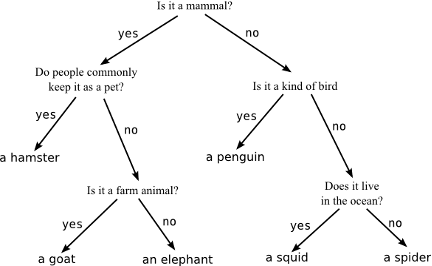

* A ﬂowchart-like structure
* Each internal node represents a test on an attribute
* Each branch represents the outcome of the test
* Each leaf node represents a class label
* The paths from root to leaf represent classiﬁcation rules.

Pros and cons?
* Simple
* White-box
* Sensitive to data ('high variance')
* May require many levels
* Generally low accuracy

Let's build the model. There are generally 4 steps:
1. Set-up the model:

In [ ]:
import sklearn.tree
modelTree = sklearn.tree.DecisionTreeClassifier(random_state = 42)

2. Fit the tree using the training data:

In [ ]:
resultTree = modelTree.fit(featuresTrain, outcomeTrain)
sklearn.tree.plot_tree(resultTree, feature_names = list(features), filled = True,\
                       class_names = modelTree.classes_, max_depth = 2)

To actually see the tree, you can run this code:

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25,20))
_ = sklearn.tree.plot_tree(resultTree, feature_names = list(features), filled = True,\
                       class_names = modelTree.classes_, max_depth = 2)

# To save the tree as a png file:
# fig.savefig("decision_tree.png")

3. Use the fitted model to predict outcomes:

In [ ]:
predTreeTrain = modelTree.predict(featuresTrain)
predTreeTrain

4. Assess the fit:

In [ ]:
sklearn.metrics.r2_score(outcomeTrain, featuresTrain) # this is wrong

What happened?

Metrics like $R^2$, mean squared error, mean absolute error, etc., make sense for regression, but not classification.

How can we tell if a model is good or bad?
* Depends on the reference
  - "Better or worse" more than "good or bad"
* Depends on the dependent variable
* Depends on the kind of model
* Depends on the goal

What outcomes are we trying to predict?

In [ ]:
pd.value_counts(outcomeTrain)

What did the model predict?

In [ ]:
pd.value_counts(predTreeTrain)

So, we know the prediction isn't perfect. But what did it miss? How imperfect?

### Confusion Matrix

Check the confusion matrix to assess the model's goodness of fit:

In [ ]:
sklearn.metrics.accuracy_score(outcomeTrain, predTreeTrain)
cmTreeTrain = sklearn.metrics.confusion_matrix(outcomeTrain, predTreeTrain)
sklearn.metrics.ConfusionMatrixDisplay(cmTreeTrain, display_labels = modelTree.classes_).plot()

We can quickly look at many metrics with the `classification_report`:

In [ ]:
print(sklearn.metrics.classification_report(outcomeTrain, predTreeTrain))

* Out of all the people that the model predicted Missed, 99% actually Missed
* Out of all the people that actually Missed, the model predicted 100% of them
* Out of all the people that the model predicted Paid, 100% actually Paid
* Out of all the people that actually Paid, the model predicted 100% of them
* Support tells us how many of each case are in the data

It's no surprise that the model does well on the training data that was used to build it. 

The real "test" (forgive the pun) is to see how the model fits the test data to assess overfitting:

In [ ]:
# First create the predictions on the test data
predTreeTest = modelTree.predict(featuresTest)

# Then assess the fit
cmTreeTest = sklearn.metrics.confusion_matrix(outcomeTest, predTreeTest)
sklearn.metrics.ConfusionMatrixDisplay(cmTreeTest, display_labels = modelTree.classes_).plot()
print(sklearn.metrics.classification_report(outcomeTest, predTreeTest))

How did the model do at predicting new data?
* Bad overfitting
* Decision trees, while nice to look at, are terrible about overfit

## Random Forests

The steps are the same for random forests as they are for decision trees, with the exception that you use `sklearn.ensemble.RandomForestClassifier` to build the model:

In [ ]:
# 1. Set-up the model
import sklearn.ensemble
modelForest = sklearn.ensemble.RandomForestClassifier(random_state = 42)

# 2. Fit the model using the training data
resultForest = modelForest.fit(featuresTrain, outcomeTrain)

# 3. Predict outcomes from the training and testing data
predForestTrain = modelForest.predict(featuresTrain)
predForestTest = modelForest.predict(featuresTest)

# 4. Assess the fit
print(sklearn.metrics.classification_report(outcomeTrain, predForestTrain))
print(sklearn.metrics.classification_report(outcomeTest, predForestTest))

## Neural Network

1. Set-up the model using `sklearn.neural_network.MLPClassifier`:

In [ ]:
import sklearn.neural_network
modelNeural = sklearn.neural_network.MLPClassifier(hidden_layer_sizes = (50, 50), random_state = 42)

Steps 2-4 are exactly the same as for Decision Trees and Random Forests. Refer to the code above to fit the model, make predictions, and assess the fit (for both training and test data sets):

## Try Another...

Instead of repeating the class exercise, use the 3 models we covered in class to try to classify the Species of flower in the data set, "Iris.csv":